<a href="https://colab.research.google.com/github/AnnCherk/Introduction-to-ML/blob/main/Log_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Установите количество пропущенных значений поля <code>age</code>:

In [103]:
df = pd.read_csv('titanic_train.csv')

missing_age_count = df['age'].isnull().sum()

print(f'Количество пропущенных значений в поле "age": {missing_age_count}')

Количество пропущенных значений в поле "age": 199


Определите долю выживших

In [104]:
survived_count = df['survived'].sum()

# Подсчет общего количества пассажиров
total_passengers = df.shape[0]

# Расчет доли выживших
survival_rate = survived_count / total_passengers

# Вывод результата
print(f'Доля выживших:', round(survival_rate, 3))

Доля выживших: 0.382


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [105]:
# Определение доли пропущенных значений для каждого признака
missing_values = df.isnull().mean()

# Вывод доли пропущенных значений
print("Доля пропущенных значений по признакам:")
print(missing_values)

# Избавление от признаков, где доля пропусков больше трети
threshold = 1/3
columns_to_drop = missing_values[missing_values > threshold].index
df = df.drop(columns=columns_to_drop)

# Удаление колонки 'ticket'
df = df.drop(columns='ticket')

Доля пропущенных значений по признакам:
pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64


In [106]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [107]:
# Замена колонок 'sibsp' и 'parch' на колонку 'fam_size'
df['fam_size'] = df['sibsp'] + df['parch']
df = df.drop(columns=['sibsp', 'parch'])

# Вычисление выборочного среднего колонки 'fam_size'
mean_fam_size = df['fam_size'].mean()

# Вывод результата
print("\nОбновленный датасет:")
print(df.head())

print(f"\nВыборочное среднее значение колонки 'fam_size': {mean_fam_size:.3f}")


Обновленный датасет:
   pclass  survived                                             name     sex  \
0       3         1                               Smyth, Miss. Julia  female   
1       3         1                         Glynn, Miss. Mary Agatha  female   
2       3         1  Whabee, Mrs. George Joseph (Shawneene Abi-Saab)  female   
3       3         0                                  Vovk, Mr. Janko    male   
4       3         0                        de Pelsmaeker, Mr. Alfons    male   

    age    fare embarked  fam_size  
0   NaN  7.7333        Q         0  
1   NaN  7.7500        Q         0  
2  38.0  7.2292        C         0  
3  22.0  7.8958        S         0  
4  16.0  9.5000        S         0  

Выборочное среднее значение колонки 'fam_size': 0.866


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [108]:
num_predictors = df.shape[1] - 1
print(f"Число предикторов: {num_predictors}")

Число предикторов: 7


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [109]:
# Фильтрация данных для мужчин с классом билета 3
male_pclass3 = df[(df['sex'] == 'male') & (df['pclass'] == 3)]

# Подсчет вероятности выживания
survival_probability = male_pclass3['survived'].mean()

# Вывод результата
print(f"Вероятность выживания для мужчин с классом билета 3: {survival_probability:.3f}")

Вероятность выживания для мужчин с классом билета 3: 0.164


Постройте гистограммы выжиших и невыживших по возрастам.

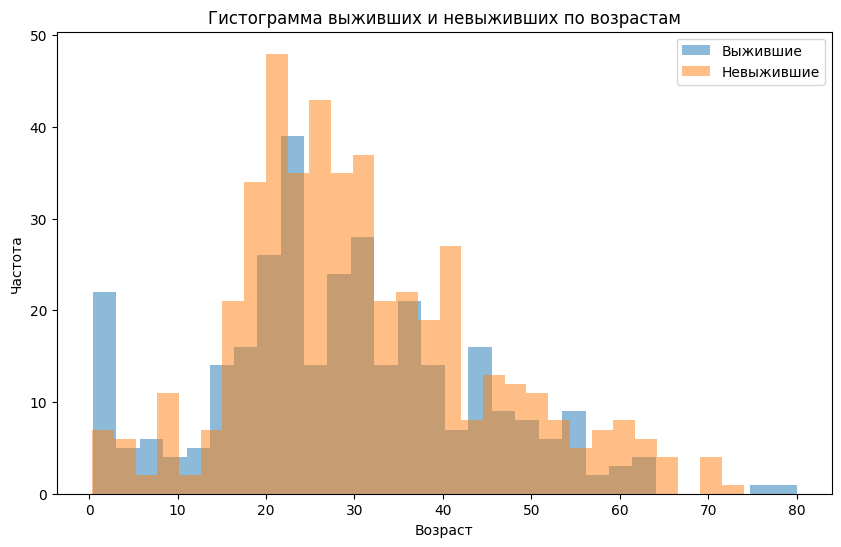

In [110]:
# Разделение данных на выживших и невыживших
survived = df[df['survived'] == 1]
not_survived = df[df['survived'] == 0]

# Построение гистограмм
plt.figure(figsize=(10, 6))

# Гистограмма для выживших
plt.hist(survived['age'].dropna(), bins=30, alpha=0.5, label='Выжившие')

# Гистограмма для невыживших
plt.hist(not_survived['age'].dropna(), bins=30, alpha=0.5, label='Невыжившие')

# Настройка графика
plt.title('Гистограмма выживших и невыживших по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.legend()

# Отображение графика
plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Отбор только числовых признаков
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df[numeric_features]

# Удаление строк, содержащих пропуски
df_numeric = df_numeric.dropna()

# Разделение на признаки (X) и целевую переменную (y)
X = df_numeric.drop('survived', axis=1)
y = df_numeric['survived']

# Разделение на обучающую и тестовую выборки с использованием стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

# Создание и обучение модели LogisticRegression
model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=21, max_iter=1000))
])

model.fit(X_train, y_train)

# Прогноз на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score модели на тестовых данных
f1 = f1_score(y_test, y_pred)

# Вывод результата
print(f"F1 Score на тестовых данных: {f1:.3f}")

F1 Score на тестовых данных: 0.566


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [112]:
# Отбор только числовых признаков
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df[numeric_features]

# Заполнение пропущенных значений средними по столбцу
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Разделение на признаки (X) и целевую переменную (y)
X = df_numeric_imputed.drop('survived', axis=1)
y = df_numeric_imputed['survived']

# Разделение на обучающую и тестовую выборки с использованием стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

# Создание и обучение модели LogisticRegression
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=21, max_iter=1000))
])

model.fit(X_train, y_train)

# Прогноз на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score модели на тестовых данных
f1 = f1_score(y_test, y_pred)

# Вывод результата
print(f"F1 Score на тестовых данных: {f1:.3f}")

F1 Score на тестовых данных: 0.476


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [113]:
# Извлечение обращений из столбца "name"
df['honorific'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Вычисление числа уникальных обращений
unique_honorifics = df['honorific'].nunique()

# Вывод результата
print(f"Число уникальных обращений: {unique_honorifics}")

# Просмотр примеров уникальных обращений
print("\nПримеры уникальных обращений:")
print(df['honorific'].unique())

Число уникальных обращений: 14

Примеры уникальных обращений:
['Miss' 'Mrs' 'Mr' 'Master' 'Mlle' 'Rev' 'Ms' 'Col' 'Dona' 'Dr' 'Countess'
 'Major' 'Don' 'Capt']


Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [114]:
# Извлечение обращений из столбца "name"
df['honorific'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Замены обращений
df['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr', inplace=True)
df['honorific'].replace(['Dona', 'Countess'], 'Mrs', inplace=True)
df['honorific'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)

# Вычисление доли строк со значением "Master" относительно числа всех мужчин
master_ratio = df[df['honorific'] == 'Master'].shape[0] / df[df['sex'] == 'male'].shape[0]

# Вывод результата
print(f"Доля строк со значением 'Master' относительно числа всех мужчин: {master_ratio:.3f}")

Доля строк со значением 'Master' относительно числа всех мужчин: 0.072


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [115]:
# Извлечение обращений из столбца "name"
df['honorific'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Замены обращений
df['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr', inplace=True)
df['honorific'].replace(['Dona', 'Countess'], 'Mrs', inplace=True)
df['honorific'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)

# Вычисление среднего возраста категории "Mr"
average_age_mr = df[df['honorific'] == 'Mr']['age'].mean()

# Вывод результата
print(f"Средний возраст категории 'Mr': {average_age_mr:.3f} лет")

Средний возраст категории 'Mr': 32.900 лет


Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Загрузка исходного датасета
df = pd.read_csv('titanic_train.csv')

# Извлечение обращений из столбца "name"
df['honorific'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Замены обращений
df['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr', inplace=True)
df['honorific'].replace(['Dona', 'Countess'], 'Mrs', inplace=True)
df['honorific'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)

# Создание и применение стратегии заполнения пропущенных значений
imputer = SimpleImputer(strategy='mean')
df['age'] = df.groupby('honorific')['age'].transform(lambda x: x.fillna(x.mean()))

# Оставляем только числовые признаки
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df[numeric_features]

# Удаляем нечисловые и ненужные признаки
df_numeric = df_numeric.drop([ 'pclass', 'sibsp', 'parch'], axis=1)

# Разделение на признаки (X) и целевую переменную (y)
X = df_numeric.drop('survived', axis=1)
y = df_numeric['survived']

# Разделение на обучающую и тестовую выборки с использованием стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

# Создание и обучение модели LogisticRegression
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=21, max_iter=1000))
])

model.fit(X_train, y_train)

# Прогноз на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score модели на тестовых данных
f1 = f1_score(y_test, y_pred)

# Вывод результата
print(f"F1 Score на тестовых данных: {f1:.3f}")

F1 Score на тестовых данных: 0.333


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
# < ENTER YOUR CODE HERE >